# Common Emitter Biasing

> Ref:
> * Introduction to Radio Frequency Design, Wes Hayward [Page 10]



In [4]:
import math

import ipywidgets as widgets
import numpy as np
import pint
import plotly.graph_objects as go
import plotly.io as pio
import schemdraw as schem
import schemdraw.elements as e
from eseries import E12, E24, E48, erange, find_nearest
from ipywidgets import Layout, interact, interact_manual
from schemdraw import dsp  # , flow

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Support rendering plots in github
pio.renderers.default = "jupyterlab+png"
schem.use("svg")

ureg = pint.UnitRegistry()
layout = Layout(width="auto")
style = {"description_width": "50px"}

###############################################################


def draw_ce_bias(
    Vcc=12.0,
    R1=4700.0,
    R2=2200.0,
    R3=510.0,
    R4=100.0,
    R5=100.0,
    Beta=100.0,
    Vdelta=0.65,
):
    Ie = Ib = Ibias = 0.0
    Vb = Vc = Vtc = Ve = 0.0

    Vb = (Vcc * R2 * R3 + Vdelta * R2 * (R4 + (R1 / (Beta + 1)))) / (
        R3 * R4 + R2 * R4 + R2 * R3 + R1 * R3 + R1 * R2 / (Beta + 1)
    )

    Vtc = (R1 * Vcc + R4 * Vb + Beta * R1 * R4 * (Vdelta - Vb) / (R3 * (Beta + 1))) / (
        R1 + R4
    )

    Ib = (Vb - Vdelta) / (R3 * (Beta + 1))

    Ie = Ib * (Beta + 1)

    Ve = Ie * R3

    Vc = Vtc - (Beta * Ib * R5)

    Ibias = Vb / R2  # to match EMRFD LADPAC 2008 biasnpn08.exe

    Isupply = Ie + Ibias

    efficiency = 50 / 100  # 50% for class-A
    Pcd = (Vc - Ve) * Ib * Beta  # match to EMRFD LADPAC 2008 biasnpn08.exe

    vb_alert = ""
    if Vb > Vc:
        vb_alert = "$V_b$ MUST be less than $V_c$!!!"

    d = schem.Drawing()

    d += e.GroundChassis().label(
        "$I_{bias}$" + f"\n{(Ibias * ureg.ampere):.3f~#P}", color="red", loc="bot"
    )
    d += e.Resistor().label(f"$R_2$\n{(R2 * ureg.ohms):.1f~#P}", color="blue").up()
    d += e.Dot().label(
        f"$V_b$\n{(Vb * ureg.volts):.3f~#P}\n{vb_alert}", loc="left", color="red"
    )
    d.push()
    d += e.Resistor().label(f"$R_1$\n{(R1 * ureg.ohms):.1f~#P}", color="blue")
    d += e.Line().length(1).right()
    d += e.Arrow().reverse().length(2)
    d += e.Dot().label(
        "$V^'_c$" + f"\n{(Vtc * ureg.volts):.3f~#P}", loc="right", color="red"
    )
    d.pop()
    d += (
        e.Arrow()
        .right()
        .label(f"$I_b$\n{(Ib * ureg.ampere):.3f~#P}", color="red")
        .length(1.75)
    )
    d += e.Line().length(0.5)
    d += (TR1 := e.BjtNpn(circle=True).label(f"$\\beta$={Beta}", color="blue"))

    d += (
        e.Resistor()
        .label(f"$R_5$\n{(R5 * ureg.ohms):.1f~#P}", color="blue")
        .up()
        .at(TR1.collector)
        .length(2.25)
    )
    d += e.Resistor().label(
        f"$R_4$\n{(R4 * ureg.ohms):.1f~#P}", color="blue", loc="bot"
    )
    d += e.Dot(open=True).label(
        "$+V_{cc}$" + f"\n{(Vcc * ureg.volts):.1f~#P}", color="blue"
    )

    d += e.Line().length(0.25).up().at(TR1.collector)
    d += e.Dot()
    d += e.Line().right().length(1.5)
    d += e.Dot(open=True).label(
        "$V_c$" + f"\n{(Vc * ureg.volts):.3f~#P}", loc="right", color="red"
    )

    d += e.Line().length(0.25).down().at(TR1.emitter)
    d += e.Dot()
    d.push()
    d.push()
    d += (
        e.Arc2(arrow="<->", radius=0.6, color="red")
        .linewidth(0.5)
        .at(TR1.emitter, dx=-0.2, dy=-0.2)
        .to(TR1.base, dx=-0.2, dy=-0.2)
        .label("$\\Delta V$" + f"\n{(Vdelta * ureg.volts):~#P}", ofst=(-0.25, -0.25))
    )
    d.pop()
    d += e.Line().right().length(1.5)
    d += e.Dot(open=True).label(
        f"$V_e$\n{(Ve * ureg.volts):.3f~#P}", loc="right", color="red"
    )
    d.pop()
    d += (
        e.Arrow()
        .label(f"$I_e$\n{(Ie * ureg.ampere):.3f~#P}", loc="bot", color="red")
        .length(1)
    )
    d += (
        e.Resistor()
        .down()
        .label(f"$R_3$\n{(R3 * ureg.ohms):.1f~#P}", color="blue")
        .length(2)
    )
    d += e.GroundChassis()

    d += (
        e.Gap()
        .down()
        .length(3)
        .label(
            f"$I_{{supply}}$={(Isupply * ureg.ampere):.3f~#P}\n---\nCollector Dissipation={(Pcd * ureg.watts):.3f~#P}",
            color="red",
            loc="bot",
        )
    )

    return d


# draw_ce_bias().draw()

In [5]:
@interact(
    Vcc=widgets.FloatText(
        value=12.0,
        description="$V_{cc}$",
        style=style,
        # layout=layout,
    ),
    R1=widgets.SelectionSlider(
        value=4700.0,
        description="$R_1$",
        options=list(erange(E24, 100.0, 200000.0)),
        style=style,
        layout=layout,
    ),
    R2=widgets.SelectionSlider(
        value=2200.0,
        description="$R_2$",
        options=list(erange(E24, 100.0, 200000.0)),
        style=style,
        layout=layout,
    ),
    R3=widgets.SelectionSlider(
        value=510.0,
        description="$R_3$",
        options=list(erange(E24, 100.0, 200000.0)),
        style=style,
        layout=layout,
    ),
    R4=widgets.SelectionSlider(
        value=100.0,
        description="$R_4$",
        options=list(erange(E24, 100.0, 200000.0)),
        style=style,
        layout=layout,
    ),
    R5=widgets.SelectionSlider(
        value=100.0,
        description="$R_5$",
        options=[
            0,
        ]
        + list(erange(E24, 100.0, 200000.0)),
        style=style,
        layout=layout,
    ),
    Beta=widgets.FloatText(
        value=100.0,
        description="$\\beta$",
        style=style,
        # layout=layout,
    ),
    Vdelta=widgets.FloatText(
        value=0.65,
        description="$\\Delta V$",
        style=style,
        # layout=layout,
    ),
)
def interactive_draw_ce_bias(
    Vcc=12.0, R1=5000.0, R2=5000.0, R3=200.0, R4=1000.0, R5=0.0, Beta=100.0, Vdelta=0.6
):
    return draw_ce_bias(
        Vcc=Vcc, R1=R1, R2=R2, R3=R3, R4=R4, R5=R5, Beta=Beta, Vdelta=Vdelta
    )

interactive(children=(FloatText(value=12.0, description='$V_{cc}$', style=DescriptionStyle(description_width='…

Assuming $R_5$ is initially zero.  The node $V^{'}_c$ is described using:

$$
\frac{V_{cc} - V^{'}_c}{R_4} = \beta I_b + \frac{V^{'}_c - V_b}{R_1}
$$

at the base:

$$
\frac{V^{'}_c - V_b}{R_1} = I_b + \frac{V_b}{R_2}
$$

the base current being related to base voltage using:

$$
\frac{V_b - \Delta V}{R_3} = I_b (\beta + 1)
$$

Solving for $V_b$:

$$
V_b = \frac{V_{cc} R_2 R_3 + \Delta V R_2 [R_4 + \frac{R_1}{(\beta + 1)}]}{R_3 R_4 + R_2 R_4 + R_2 R_3 + R_1 R_3 + \frac{R_1 R_2}{(\beta + 1)}}
$$

for $V^{'}_c$:

$$
V^{'}_c = \frac{R_1 V_{cc} + R_4 V_b + \beta R_1 R_4 \frac{\Delta V - V_b}{R_3 (\beta + 1)} }{R_1 + R_4}
$$

for $I_b$:

$$
I_b = \frac{V_b - \Delta V}{R_3 (\beta + 1)}
$$

then $I_e$ is:

$$
I_e = I_b (\beta + 1)
$$

Once the above has been resolved, $R_5$ can be added.  Final collector voltage is:

$$
V_c = V^{'}_c - \beta I_b R_5
$$

assert $V_b < V_c$

The Transistor's collector power dissipation can be given as:

$$
P_{cd} = (V_c - V_e) I_b \beta
$$

### Reference example from EMRFD Ladpac-2008 biasnpn08.exe (run under win32 on linux):

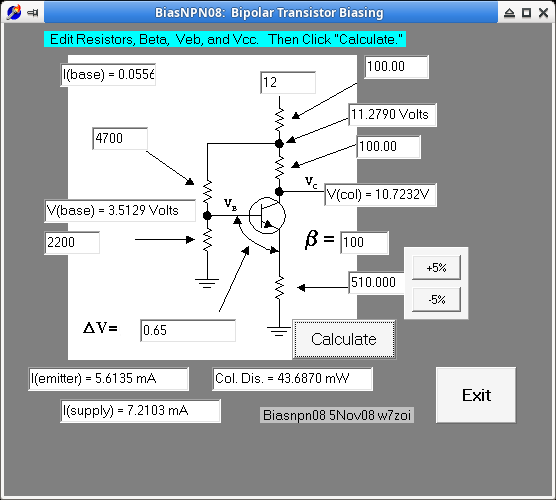

### Results: Notebook using same component values as above:

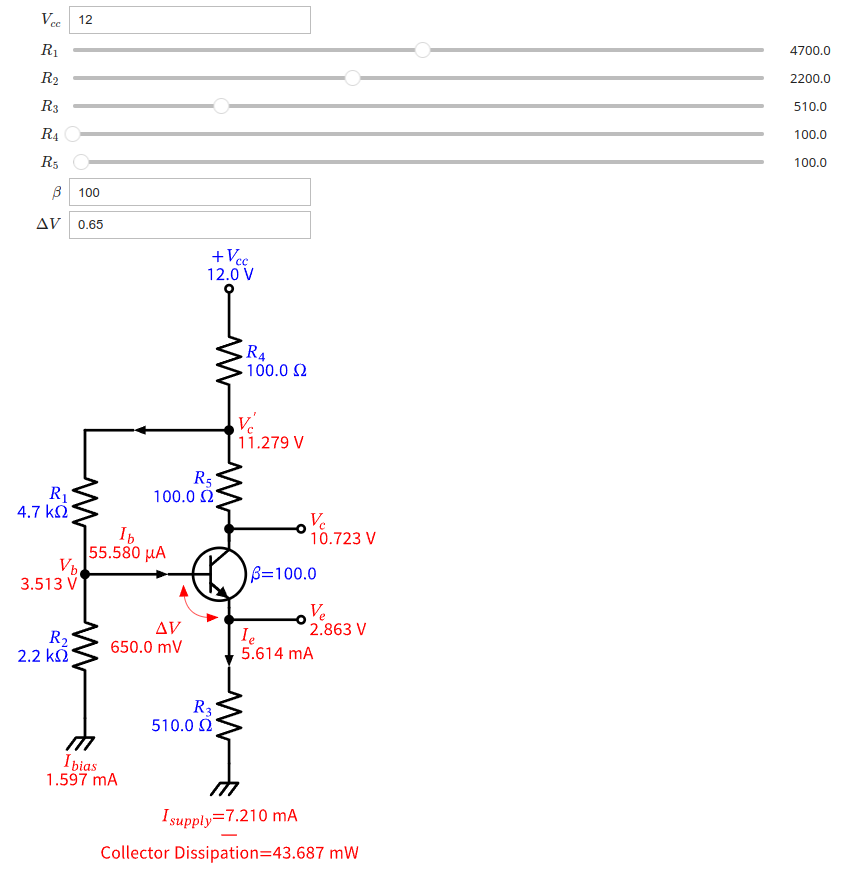